In [502]:
import tcod.map
import numpy as np
import matplotlib.pyplot as plt
import skimage.draw
import random

In [503]:
class Shape:
    def __init__(self, x, y, w, h):
        self.x1 = x
        self.y1 = y
        self.x2 = x + w
        self.y2 = y + h
        self.rr = None
        self.cc = None
    
    def center(self):
        center_x = int(np.median(self.cc))
        center_y = int(np.median(self.rr))
        return center_x, center_y

    
    def intersect(self, other):
        return (
            self.x1 <= other.x2 and
            self.x2 >= other.x1 and
            self.y1 <= (other.y2 + 2) and
            self.y2 >= (other.y1 - 2)
        )

    def create_floor(self, game_map):
        game_map.walkable[self.rr, self.cc] = True
        game_map.transparent[self.rr, self.cc] = True


class Rect(Shape):
    def __init__(self, x, y, w, h):
        super().__init__(x, y, w, h)
        self.rr, self.cc = skimage.draw.polygon(
            r=[y, y + h, y + h, y],
            c=[x, x, x + w, x + w]
        )


class Ellipse(Shape):
    def __init__(self, x, y, w, h):
        super().__init__(x, y, w, h)
        self.rr, self.cc = skimage.draw.ellipse(
            r=int(y+h/2),
            c=int(x+w/2),
            r_radius=int(h/2),
            c_radius=int(w/2),
            rotation=random.randint(0, 360)
        )

        
class Irregular(Shape):
    def __init__(self, x, y, w, h, map_width=80, map_height=40, is_rect=True):
        super().__init__(x, y, w, h)
        self.rr, self.cc = self._draw_iregular_shape(w, h, map_width, map_height, is_rect)
        
    def _draw_iregular_shape(self, w, h, map_width, map_height, is_rect):
        while True:
            angle = np.linspace(0, 2 * np.pi, 50)

            # circle coordinates
            r_circle = np.sqrt((w/2)**2 + (h/2)**2)
            x = np.round(np.cos(angle)*r_circle, 2)
            y = np.round(np.sin(angle)*r_circle, 2)

            # rectangle coordinates
            if is_rect:
                x[x > w/2] = w/2
                x[x < -w/2] = -w/2
                y[y > h/2] = h/2
                y[y < -h/2] = -h/2

            # noise for x coordinate
            noise1 = tcod.noise.Noise(
                dimensions=1,
                algorithm=tcod.NOISE_SIMPLEX,
                implementation=tcod.noise.FBM,
                hurst=0.5,
                lacunarity=2,
                octaves=4,
            )

            # noise for y coordinate
            noise2 = tcod.noise.Noise(
                dimensions=1,
                algorithm=tcod.NOISE_SIMPLEX,
                implementation=tcod.noise.FBM,
                hurst=0.5,
                lacunarity=2,
                octaves=4,
            )

            # Return the sampled noise from the grid of points.
            xn = noise1.sample_ogrid([angle])
            yn = noise2.sample_ogrid([angle])

            # start and end return to zero
            xn[:20] = xn[:20] * np.arange(0, 1, 0.05)
            xn[-20:] = xn[-20:] * np.arange(1, 0, -0.05)
            yn[:20] = yn[:20] * np.arange(0, 1, 0.05)
            yn[-20:] = yn[-20:] * np.arange(1, 0, -0.05)

            # add noise 
            x = x + x * xn
            y = y + y * yn

            # move origin point
            x = self.x1 + x - min(x) #+ 3
            y = self.y1 + y - min(y) #+ 4

            # update width, height
            self.x2 = int(self.x1 + max(x) - min(x)) 
            self.y2 = int(self.y1 + max(y) - min(y)) 

            # move room back in bound
            if self.x2 >= map_width-1:
                diff = int(self.x2 - map_width) + 2
                x -= diff
                self.x1 -= diff
                self.x2 -= diff

            if self.y2 >= map_height-1:
                diff = int(self.y2 -map_height) + 2
                y -= diff
                self.y1 -= diff
                self.y2 -= diff

            if self.x1 <= 0:
                diff = -self.x1 + 2
                x += diff
                self.x1 += diff
                self.x2 += diff

            if self.y1 <= 0:
                diff = -self.y1 + 2
                y += diff
                self.y1 += diff
                self.y2 += diff
            
            # there's a bug somewhere... Make sure its definitely in bound 
            if self.x1>0 or self.x2>0 or self.y2<map_height or self.x2<map_width:
                return skimage.draw.polygon(y, x)

                
            
        

In [504]:
def create_h_tunnel(game_map, x1, x2, y):
    game_map.walkable[y, min(x1, x2):max(x1, x2) + 1] = True
    game_map.transparent[y, min(x1, x2):max(x1, x2) + 1] = True


def create_v_tunnel(game_map, y1, y2, x):
    game_map.walkable[min(y1, y2):max(y1, y2) + 1, x] = True
    game_map.transparent[min(y1, y2):max(y1, y2) + 1, x] = True
    

def create_d_tunnel(game_map, x1, y1, x2, y2):
    x_offset, y_offset = 0, 0
    x_diff = max(x2, x1) - min(x2, x1)
    y_diff = max(y2, y1) - min(y2, y1)
    if  x_diff > y_diff:
        x_offset = 1
    else:
        y_offset = 1

    rr1, cc1 = skimage.draw.line(y1, x1, y2, x2)
    rr2, cc2 = skimage.draw.line(y1 + y_offset , x1+x_offset, y2 + y_offset, x2+x_offset)
    game_map.walkable[rr1, cc1] = True
    game_map.walkable[rr2, cc2] = True
    game_map.transparent[rr1, cc1] = True
    game_map.transparent[rr2, cc2] = True
    

    

In [505]:
class Level:
    def __init__(self, max_rooms, room_min_size, room_max_size, map_width, map_height):
        self.m = tcod.map.Map(width=80, height=45)
        self.max_rooms = max_rooms
        self.room_min_size = room_min_size
        self.room_max_size = room_max_size
        self.map_width = map_width
        self.map_height = map_height
        self.rooms = []
    
    def _gen_room(self):
        while True:
            w = random.randint(self.room_min_size, self.room_max_size)
            h = random.randint(self.room_min_size, self.room_max_size)
            x = random.randint(1, self.map_width - w - 1)
            y = random.randint(1, self.map_height - h - 1)
            

            room_type = random.random()
            
            if room_type < 0.6:
                room = Irregular(x, y, min(w, 9) , min(h, 7), self.map_width, self.map_height,  is_rect=True)
            elif room_type < 0.95:
                room = Irregular(x, y, min(w, 7) , min(h, 5), self.map_width, self.map_height,  is_rect=False)
            elif room_type < 0.99:
                room = Ellipse(x, y, w, h)
            else:
                room = Rect(x, y, w, h)
            for r in self.rooms:
                if room.intersect(r):
                    break
            else:
                self.rooms.append(room)
                break
            
        room.create_floor(self.m)

    def _gen_corridor(self):
        new_x, new_y = self.rooms[-1].center()
        prev_x, prev_y = self.rooms[-2].center()
        
        corridor_type = random.random()
 
        if corridor_type < 0.425:
            create_h_tunnel(self.m, prev_x, new_x, prev_y)
            create_v_tunnel(self.m, prev_y, new_y, new_x)
        elif corridor_type >= 0.425 and corridor_type < 0.85:
            create_v_tunnel(self.m, prev_y, new_y, prev_x)
            create_h_tunnel(self.m, prev_x, new_x, new_y)
        else:
            create_d_tunnel(self.m, prev_x, prev_y, new_x, new_y)

    def make_map(self):
        for r in range(self.max_rooms):
            self._gen_room()
            if len(self.rooms) > 1:
                self._gen_corridor()
            


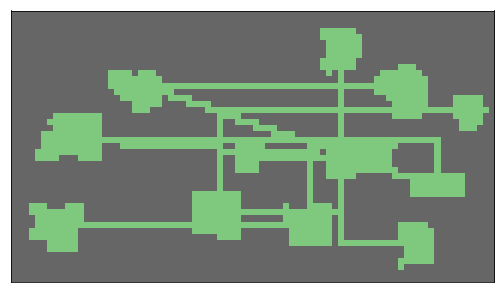

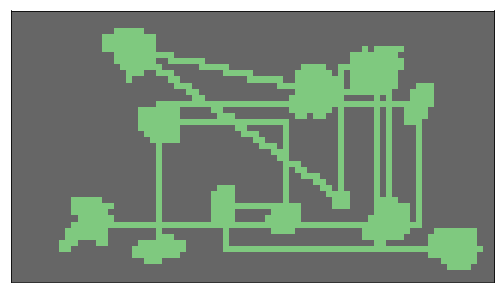

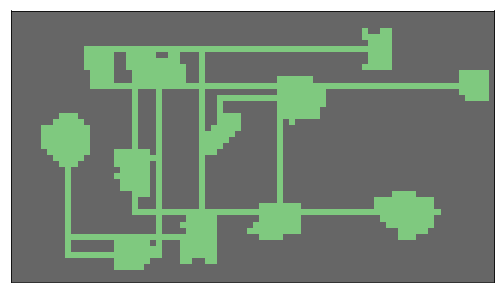

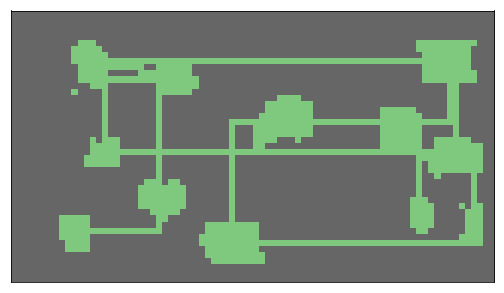

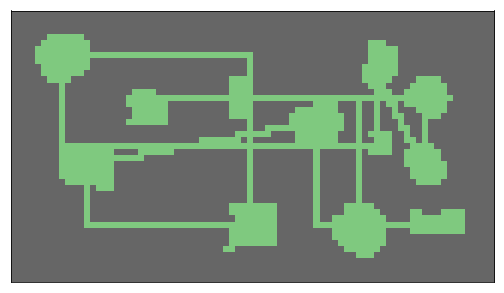

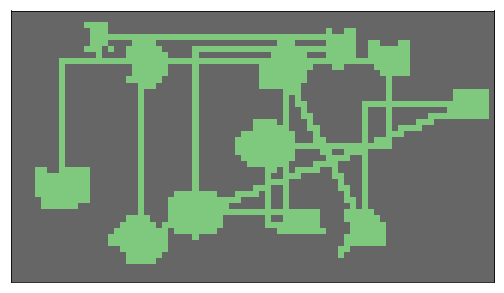

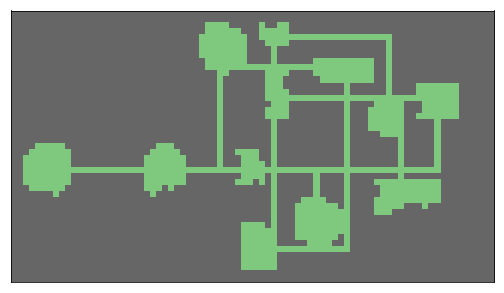

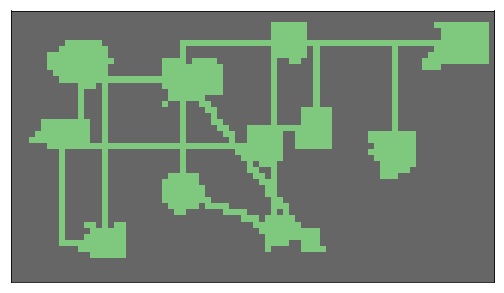

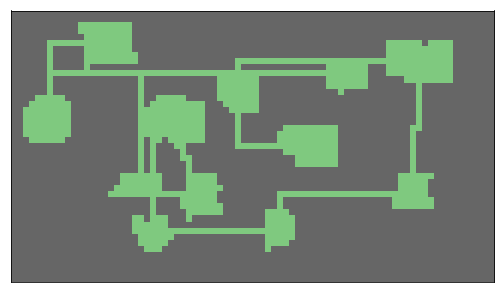

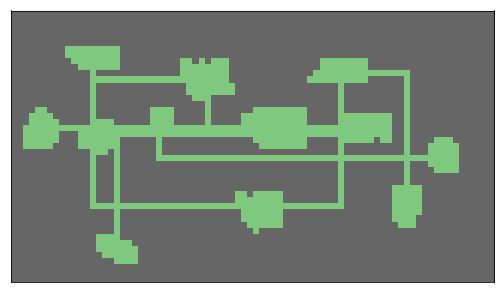

In [506]:
def show_map(level):
    plt.figure(figsize=(10,5))
    plt.imshow(
        level.m.walkable,
        cmap=plt.cm.Accent_r,
        interpolation='nearest'
    )
    plt.xticks([]),plt.yticks([])
    plt.show()

for _ in range(10):
    lvl = Level(12, 4, 10, 80, 45)
    lvl.make_map()
    show_map(lvl)